### Set up dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import utils
from BatchLoader2 import BatchLoader2 as BatchLoader
from datetime import datetime
from io import StringIO
from PIL import Image
import time

### Set up given parameters and hyperparameters

In [2]:
HEIGHT, WIDTH = 128, 128
NUMBER_CHANNELS = 1
NUMBER_OUTPUT_CLASS = 2
NUMBER_OUTPUT_LOC = 2
GPU_OPTS = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

LEARNING_RATE = 1e-4
BATCH_SIZE = 64
MAX_EPOCHS = 150

### Building different types of networks for the experiments

In [3]:
#Build a building block for features, if poolsize and stride is the same, then the poolings are not overlapping
def conv_pool_drop(x,filters,kernel,pool,stride,keep_prob=1.0, counter=1, padding='same',use_avg=True,trace=False):
    with tf.variable_scope('conv'+str(counter)):
        lc1 = tf.layers.conv2d(x, filters, kernel, (1,1), padding=padding) #Do not downsample with cross-correlation
        if(trace is True):
            print(lc1)
    with tf.variable_scope('maxpool'+str(counter)):
        lp1 = tf.layers.max_pooling2d(lc1,pool,stride) #Pool it to downsample
        if(trace is True):
            print(lp1)
    if(use_avg is True):
        with tf.variable_scope('avgpool'+str(counter)): #We also introduce average pooling as maxpooling is rather agressive
            lap1 = tf.layers.average_pooling2d(lc1,pool,stride)
            if(trace is True):
                print(lap1)
        with tf.variable_scope('mergepool'+str(counter)):
            m1 = tf.concat([lp1,lap1],axis=3)
            if(trace is True):
                print(m1)
    else:
        m1 = lp1
    with tf.variable_scope('dropout'+str(counter)):
        ld1 = tf.layers.dropout(m1,rate=1.0-keep_prob)
        if(trace is True):
            print(ld1)
    return lc1,m1,ld1

def our_network(x_pl,hyper,trace=False,use_avg=True):
    #Our architecture
    x = x_pl
    #Architecture hyperparams
    blocknumbers = hyper[0] #3
    padding = hyper[1] #'same'
    filters = hyper[2] #[8,3,3]
    kernel_size = hyper[3] #[(7,7),(5,5),(3,3)]
    stride = hyper[4] #[(3,3),(3,3),(5,5)]
    pool_size = hyper[5] #[(5,5),(5,5),(3,3)]
    denseNum = hyper[6] #512
    denseNumReg = hyper[7] #512
    keep_prob = hyper[8]#tf.placeholder("float",name="KeepProbabilityPool")
    keep_prob2 = hyper[9]#tf.placeholder("float",name="KeepProbabilityDense")
    lc = []
    m = []
    ld = []
    #Need to initialize first layer manually, such that the loop can do it automatically later on
    lc1,m1,ld1 = conv_pool_drop(x,filters[0],kernel_size[0],pool_size[0],stride[0],keep_prob=keep_prob,counter=1,trace=trace,use_avg=use_avg)
    lc.append(lc1)
    m.append(m1)
    ld.append(ld1)
    for i in range(2,blocknumbers+1):
        i2 = min(i-1,len(filters)-1) ##If there are more layers, use the settings for the last one
        lc1,m1,ld1 = conv_pool_drop(ld[-1],filters[i2],kernel_size[i2],pool_size[i2],stride[i2],keep_prob=keep_prob,counter=i,trace=trace,use_avg=use_avg)
        lc.append(lc1)
        m.append(m1)
        ld.append(ld1)
    #Flatten and concatenate to evaluate the different features separately
    flattened = [] #Contains flattened feature maps on different levels
    with tf.variable_scope("Flatten"):
        for i in range(0,len(ld)):
            flattened.append(tf.layers.flatten(ld[i]))
            if(trace is True):
                print(flattened[i])
    with tf.variable_scope("Concatenate"):
        concat = tf.concat(flattened,axis=1)
        if(trace is True):
            print(concat)
    #Dense layers with dropout
    with tf.variable_scope("DenseInterpreterClass"):
        hiddenDense = tf.layers.dense(concat,denseNum,activation=tf.nn.relu,name="hidden_DenseClass")
        if(trace is True):
            print(hiddenDense)
        doDense = tf.layers.dropout(hiddenDense,rate=1.0-keep_prob2)
        if(trace is True):
            print(doDense)
    with tf.variable_scope("DenseInterpreterRegress"):
        hiddenDenseReg = tf.layers.dense(concat,denseNumReg,activation=tf.nn.relu,name="hidden_DenseRegress")
        if(trace is True):
            print(hiddenDenseReg)
        doDenseReg = tf.layers.dropout(hiddenDenseReg,rate=1.0-keep_prob2)
        if(trace is True):
            print(doDenseReg)
        
    #Output layers
    with tf.variable_scope("Predictions"):
        l_class = tf.layers.dense(doDense,NUMBER_OUTPUT_CLASS,activation=tf.nn.softmax,name="ClassificationGuess")
        if(trace is True):
            print(l_class)
        l_loc = tf.layers.dense(doDenseReg,NUMBER_OUTPUT_LOC,activation=tf.nn.relu,name="RegressionGuess")
        if(trace is True):
            print(l_loc)
    return l_class,l_loc

def build_networks(network_type,hyper,placeholders,trace=False):
    #Input type is common in all
    x_pl = placeholders[0]
    y_pl = placeholders[1]
    y_loc = placeholders[2]
    #Set up different network architecture
    if(network_type is 1):
        hyper.append(placeholders[3]) #Keep probability1
        hyper.append(placeholders[4]) #Keep probability2
        l_class, l_loc = our_network(x_pl,hyper,trace=trace,use_avg=True)
    elif (network_type is 2):
        # Do the same as before just without the averagepooling
        hyper.append(placeholders[3])
        hyper.append(placeholders[4])
        l_class, l_loc = our_network(x_pl,hyper,trace=trace,use_avg=False)
    else:
        #Network architecture provided by TAX
        l = x_pl
        with tf.variable_scope('conv2d'):
            l = tf.layers.conv2d(l, 16*4, [3, 3], 4, padding='VALID', name='conv1')
            if(trace is True):
                print(l)
            l = tf.layers.max_pooling2d(l, [2, 2], 2, name='pool1')
            if(trace is True):
                print(l)
            l = tf.layers.conv2d(l, 16*12, [3, 3], padding='VALID', name='conv2')
            if(trace is True):
                print(l)
            l = tf.layers.max_pooling2d(l, [2, 2], 2, name='pool2')
            if(trace is True):
                print(l)
            l = tf.layers.conv2d(l, 16*24, [3, 3], padding='VALID', name='conv3')
            if(trace is True):
                print(l)
            l = tf.layers.conv2d(l, 16*32, [3, 3], padding='VALID', name='conv4')
            if(trace is True):
                print(l)
        with tf.variable_scope('flatten'):
            l = tf.layers.flatten(l)
            if(trace is True):
                print(l)
        with tf.variable_scope('fully_connected'):
            l_class= tf.layers.dense(l,2, activation=tf.nn.softmax, name="fc_last")
            if(trace is True):
                print(l)
            #Added for regression; not present in provided architecture
            l_loc = tf.layers.dense(l,2, activation=tf.nn.relu, name="fc_loc")
    print('Model consits of ', utils.num_params(), 'trainable parameters.')
    
    #Loss, training, etc
    with tf.variable_scope('loss'):
        with tf.variable_scope('loss_class'):
            # computing cross entropy per sample for classification
            cross_entropy = -tf.reduce_sum(y_pl * tf.log(l_class+1e-8), reduction_indices=[1])

            # averaging over samples
            cross_entropy = tf.reduce_mean(cross_entropy)
            tf.summary.scalar('cross_entropy',cross_entropy)

        with tf.variable_scope('loss_local'):
            #Get one-hot encoding for representing if the ball is present in the image
            ball_present = tf.cast(tf.equal(tf.argmax(y_pl,axis=1),tf.cast(1,tf.int64)),tf.float32)
            ball_present = tf.expand_dims(ball_present,1)
            #Compute mean squared error
            mse = tf.losses.mean_squared_error(y_loc,l_loc,weights=ball_present)#Ignore cases when ball is not present in image
            tf.summary.scalar('mean_sqared_error',mse)
        loss = cross_entropy+mse
        tf.summary.scalar('combined_loss',loss)
        reg_scale = 0.0005
        regularize = tf.contrib.layers.l2_regularizer(reg_scale)
        params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        reg_term = sum([regularize(param) for param in params])
        loss += reg_term
        tf.summary.scalar('reg_combined_loss',loss)
    with tf.variable_scope('training'):
        # defining our optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

        # applying the gradients
        train_op = optimizer.minimize(loss)


    with tf.variable_scope('performance_class'):
        # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
        correct_prediction = tf.equal(tf.argmax(l_class, axis=1), tf.argmax(y_pl, axis=1))

        # averaging the one-hot encoded vector
        accuracy_class = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('class_acc',accuracy_class)
    
    with tf.variable_scope('performance_local'):
        #Calculate eucledian distance between the predicted coordinates and the labelled ones
        ball_present = tf.cast(tf.equal(tf.argmax(y_pl,axis=1),tf.cast(1,tf.int64)),tf.float32)
        avgdist = ball_present*tf.norm((l_loc-y_loc)*128,axis=1,keep_dims=False,ord=2)#convert to pixel values
        avgdist = tf.reduce_sum(avgdist)/tf.maximum(1.0,tf.reduce_sum(ball_present)) #ignore predictions when ball is not present, safeguard if there is no ball in any of the pictures
        tf.summary.scalar('avg_pixel_dev',avgdist)
    merged_sum = tf.summary.merge_all()
    return l_class,train_op,accuracy_class,cross_entropy,l_loc,avgdist,loss,mse,merged_sum

### Load the checkpoint

Model consits of  5626412 trainable parameters.
INFO:tensorflow:Restoring parameters from ./checkpoints/avg/final_avgpool_1_150.0.ckpt
Ball


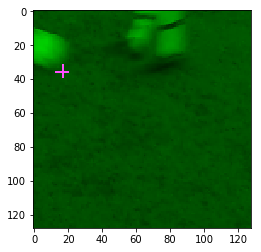

Ball


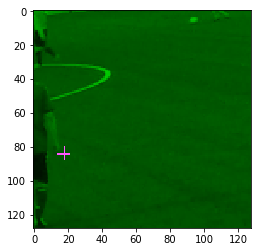

Ball


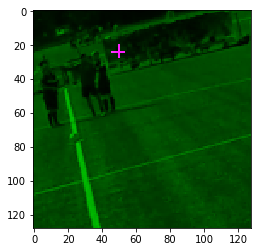

Ball


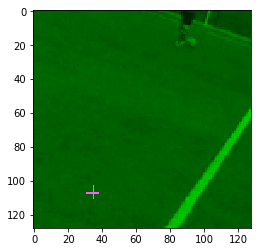

Noball


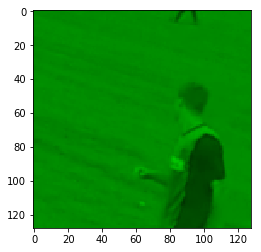

Ball


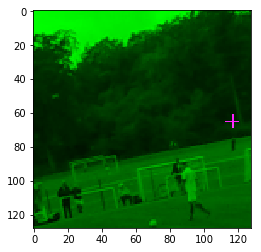

Ball


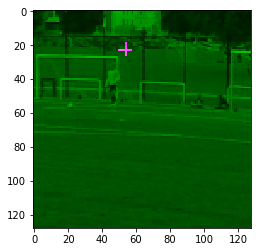

Ball


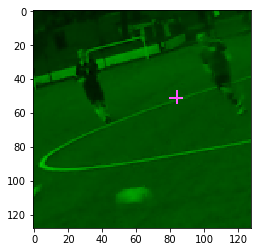

Ball


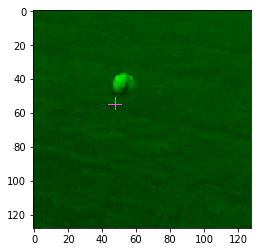

Ball


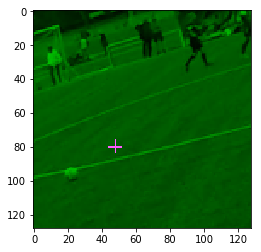

Ball


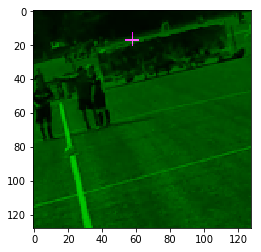

Ball


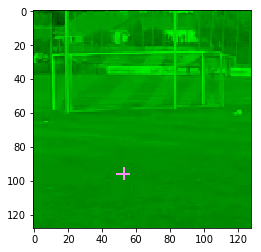

Ball


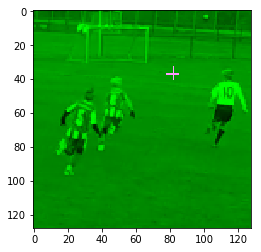

Ball


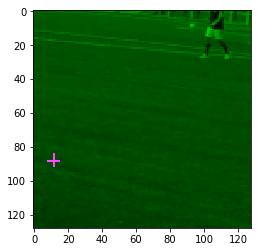

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './sample_validation/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(1, 15) ]

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
checkpoint='avg/final_avgpool_1_150.0'
#checkpoint='avg/final_avgpool_1_36.0'
#checkpoint='default/final_default_2_150.0'
#checkpoint='tax/final_tax_1_150.0'
hype=[3,'same',[8,3,3],[(7,7),(5,5),(3,3)],[(3,3),(3,3),(5,5)],[(5,5),(5,5),(3,3)],64,128]
#Reset graph before building
tf.reset_default_graph()
with tf.name_scope('input'):
    x_pl = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, NUMBER_CHANNELS], name='ImagePlaceholder')
with tf.name_scope('output'):
    y_pl = tf.placeholder(tf.float64, [None, NUMBER_OUTPUT_CLASS], name='Classification')
    y_pl = tf.cast(y_pl, tf.float32)
    #We are predicting pixel locations, in percentage of the pixel width: 1.0,1.0 corresponds to 128,128
    y_loc = tf.placeholder(tf.float64, [None, NUMBER_OUTPUT_LOC], name='Regression')
    y_loc = tf.cast(y_loc, tf.float32)
with tf.name_scope('keepProbs'):
    keep_prob = tf.placeholder("float",name="KeepProbabilityPool")
    keep_prob2 = tf.placeholder("float",name="KeepProbabilityDense")
#Setting up placeholders and hyperparameters
l_c,train_op,accuracy_class,cross_entropy,l_loc,avgdist,loss,mse,merged_sum = build_networks(ntype,hype,[x_pl,y_pl,y_loc,keep_prob,keep_prob2],trace=False)

saver = tf.train.Saver(max_to_keep=15,keep_checkpoint_every_n_hours=0.5) #keep all checkpoints
with tf.device('/cpu:0'):
    with tf.Session(config=tf.ConfigProto(gpu_options=GPU_OPTS)) as sess:
        saver.restore(sess, "./checkpoints/"+checkpoint+".ckpt")
        try:
            for image_path in TEST_IMAGE_PATHS:
                image = Image.open(image_path)
                image_np = load_image_into_numpy_array(image)/255.0
                image_np = np.delete(image_np,[0,2],axis=2)
                im = [image_np]
                feed_dict = {x_pl: im, keep_prob: 1.0, keep_prob2: 1.0}
                fetches = [l_c,l_loc]
                cl,lo =  sess.run(fetches, feed_dict)
                image_np = load_image_into_numpy_array(image)/255.0
                cl = np.argmax(cl,axis=1)
                if cl[0] == 1:
                    print("Ball")
                else:
                    print("Noball")
                image_np[:,:,0] = 0
                image_np[:,:,2] = 0
                #Add cross
                size = 4
                predx = int(round(lo[0][0]*128))
                predy = int(round(lo[0][1]*128))
                if cl[0] == 1:
                    for i in range(-size,size):
                        tempx = max(0,predx+i)
                        tempx = min(128,tempx)
                        tempy = max(0,predy+i)
                        tempy = min(128,tempy)
                        image_np[predx][tempy][0] = 1
                        image_np[predx][tempy][2] = 1
                        image_np[tempx][predy][0] = 1
                        image_np[tempx][predy][2] = 1
                plt.figure()
                plt.imshow(image_np)
                plt.show()
        except KeyboardInterrupt:
            pass